# Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV
from random import sample
import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import joblib
from imblearn.over_sampling import RandomOverSampler

# Import Data

In [2]:
SEED = 42

In [3]:
fraud_df = pd.read_csv('https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/fraud.csv',
                       parse_dates = ['signup_time','purchase_time'])

# Describe and find missing values

In [4]:
fraud_df.dtypes

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
is_fraud                   int64
dtype: object

In [5]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
fraud_df.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
is_fraud          0
dtype: int64

# Data Preprocessing

In [7]:
def process_df(original_df):
    df = original_df.copy()
    #'user_id',
    df = df.drop(columns=['device_id','source','browser',
                             'sex','ip_address'])
    df['delay_signup_purchase'] = (df['signup_time'] - df['purchase_time']).dt.seconds
    for col_prefix in ['signup', 'purchase']:
        df[f'{col_prefix}_year'] = df[f'{col_prefix}_time'].dt.year
        df[f'{col_prefix}_month'] = df[f'{col_prefix}_time'].dt.month
        df[f'{col_prefix}_weekday'] = df[f'{col_prefix}_time'].dt.weekday
        df[f'cos_{col_prefix}_month'] = np.cos(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'sin_{col_prefix}_month'] = np.sin(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'{col_prefix}_hour'] = df[f'{col_prefix}_time'].dt.hour
        df[f'cos_{col_prefix}_hour'] = np.cos(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'sin_{col_prefix}_hour'] = np.sin(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'{col_prefix}_minute'] = df[f'{col_prefix}_time'].dt.minute
        df[f'cos_{col_prefix}_minute'] = np.cos(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'sin_{col_prefix}_minute'] = np.sin(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'{col_prefix}_int_value'] = df[f'{col_prefix}_time'].apply(lambda x: x.value)
        df = df.drop(columns=[f'{col_prefix}_time'])
    return df

In [8]:
processed_balanced_fraud_df = process_df(fraud_df)

In [9]:
processed_balanced_fraud_df.head()

,user_id,purchase_value,age,is_fraud,delay_signup_purchase,signup_year,signup_month,signup_weekday,cos_signup_month,sin_signup_month,...,purchase_weekday,cos_purchase_month,sin_purchase_month,purchase_hour,cos_purchase_hour,sin_purchase_hour,purchase_minute,cos_purchase_minute,sin_purchase_minute,purchase_int_value
0,22058,34,39,0,72518,2015,2,1,0.500000,8.660254e-01,...,5,-5.000000e-01,8.660254e-01,2,8.660254e-01,0.500000,47,0.207912,-0.978148,1429325231000000000
1,333320,16,53,0,68456,2015,6,6,-1.000000,1.224647e-16,...,0,-1.000000e+00,1.224647e-16,1,9.659258e-01,0.258819,38,-0.669131,-0.743145,1433727534000000000
2,1359,15,53,1,86399,2015,1,3,0.866025,5.000000e-01,...,3,8.660254e-01,5.000000e-01,18,-1.836970e-16,-1.000000,52,0.669131,-0.743145,1420138365000000000
3,150084,44,41,0,26315,2015,4,1,-0.500000,8.660254e-01,...,0,-8.660254e-01,5.000000e-01,13,-9.659258e-01,-0.258819,54,0.809017,-0.587785,1430747690000000000
4,221365,39,45,0,44939,2015,7,1,-0.866025,-5.000000e-01,...,2,-1.836970e-16,-1.000000e+00,18,-1.836970e-16,-1.000000,40,-0.500000,-0.866025,1441824053000000000


# Split train test (ensure different users in each set train and test)

In [10]:
x_df_unb = processed_balanced_fraud_df.loc[:, processed_balanced_fraud_df.columns != 'is_fraud'].reset_index(drop=True)
y_df_unb = processed_balanced_fraud_df[['is_fraud']]
ros = RandomOverSampler(random_state=SEED)
x_df, y_df = ros.fit_resample(x_df_unb, y_df_unb)

In [11]:
x_df.head(3)

,user_id,purchase_value,age,delay_signup_purchase,signup_year,signup_month,signup_weekday,cos_signup_month,sin_signup_month,signup_hour,...,purchase_weekday,cos_purchase_month,sin_purchase_month,purchase_hour,cos_purchase_hour,sin_purchase_hour,purchase_minute,cos_purchase_minute,sin_purchase_minute,purchase_int_value
0,22058,34,39,72518,2015,2,1,0.500000,8.660254e-01,22,...,5,-0.500000,8.660254e-01,2,8.660254e-01,0.500000,47,0.207912,-0.978148,1429325231000000000
1,333320,16,53,68456,2015,6,6,-1.000000,1.224647e-16,20,...,0,-1.000000,1.224647e-16,1,9.659258e-01,0.258819,38,-0.669131,-0.743145,1433727534000000000
2,1359,15,53,86399,2015,1,3,0.866025,5.000000e-01,18,...,3,0.866025,5.000000e-01,18,-1.836970e-16,-1.000000,52,0.669131,-0.743145,1420138365000000000


In [12]:
x_df.shape

(273922, 28)

In [13]:
y_df.head(3)

,is_fraud
0,0
1,0
2,1


In [14]:
y_df.shape

(273922, 1)

In [15]:
gs = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=SEED)

In [16]:
train_indexes, test_indexes = next(gs.split(x_df, y_df, groups=x_df.user_id))

x_train = x_df.iloc[train_indexes]
y_train = y_df.iloc[train_indexes]

x_test = x_df.iloc[test_indexes]
y_test = y_df.iloc[test_indexes]

x_train = x_train.drop(columns=['user_id'])
x_test = x_test.drop(columns=['user_id'])

# Train model on train data

In [17]:
clf = lgb.LGBMClassifier()

In [18]:
#List of parameters and their values to choose randomly from
param_dist = { 'max_depth':[2, 4, 6],  
               'min_child_weight':[0.001, 0.01, 0.1, 1, 2],
               'subsample':np.arange(0.75, 0.90, 0.01),
               'colsample_bytree': np.arange(0.80, 1, 0.1), 
               'reg_alpha':[.001, .005, .0005],
               'reg_lambda':[.001, .005, .0005],
                    }

In [19]:
grid = RandomizedSearchCV(clf, param_dist, verbose=1, cv=5, n_jobs = -1, n_iter=10)
grid.fit(x_train, y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.8, 0.9]),
                                        'max_depth': [2, 4, 6],
                                        'min_child_weight': [0.001, 0.01, 0.1,
                                                             1, 2],
                                        'reg_alpha': [0.001, 0.005, 0.0005],
                                        'reg_lambda': [0.001, 0.005, 0.0005],
                                        'subsample': array([0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
       0.86, 0.87, 0.88, 0.89, 0.9 ])},
                   verbose=1)

In [20]:
optimized_model = lgb.LGBMClassifier(**grid.best_params_)

# Variable selection

In [21]:
selector = RFE(optimized_model, step=1)
selector = selector.fit(x_train, y_train.values.ravel())

In [22]:
cols_to_keep = x_train.loc[:, selector.support_].columns

In [23]:
cols_to_keep

Index(['purchase_value', 'age', 'delay_signup_purchase', 'signup_hour',
       'signup_minute', 'cos_signup_minute', 'sin_signup_minute',
       'signup_int_value', 'purchase_hour', 'sin_purchase_hour',
       'cos_purchase_minute', 'sin_purchase_minute', 'purchase_int_value'],
      dtype='object')

In [24]:
more_optimized_model = lgb.LGBMClassifier(**grid.best_params_)
more_optimized_model.fit(x_train[cols_to_keep], y_train.values.ravel())

LGBMClassifier(colsample_bytree=0.9, max_depth=6, min_child_weight=0.01,
               reg_alpha=0.001, reg_lambda=0.0005,
               subsample=0.8200000000000001)

# Discover variables importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

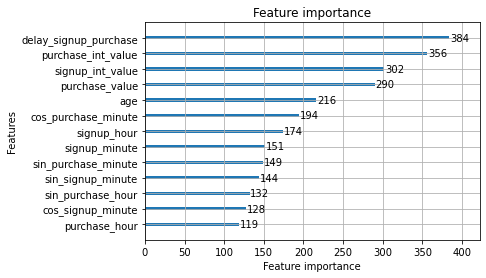

In [25]:
lgb.plot_importance(more_optimized_model)

# Tune hyperparameters after variable selection

In [26]:
clf = lgb.LGBMClassifier()

In [27]:
#List of parameters and their values to choose randomly from
param_dist = { 'max_depth':[2, 4, 6],  
               'min_child_weight':[0.001, 0.01, 0.1, 1, 2],
               'subsample':np.arange(0.75, 0.90, 0.01),
               'colsample_bytree': np.arange(0.80, 1, 0.1), 
               'reg_alpha':[.001, .005, .0005],
               'reg_lambda':[.001, .005, .0005],
                    }

In [28]:
grid = RandomizedSearchCV(clf, param_dist, verbose=1, cv=5, n_jobs = -1, n_iter=10)
grid.fit(x_train[cols_to_keep], y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.8, 0.9]),
                                        'max_depth': [2, 4, 6],
                                        'min_child_weight': [0.001, 0.01, 0.1,
                                                             1, 2],
                                        'reg_alpha': [0.001, 0.005, 0.0005],
                                        'reg_lambda': [0.001, 0.005, 0.0005],
                                        'subsample': array([0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
       0.86, 0.87, 0.88, 0.89, 0.9 ])},
                   verbose=1)

In [29]:
best_optimized_model = lgb.LGBMClassifier(**grid.best_params_)

In [30]:
best_optimized_model.fit(x_train[cols_to_keep], y_train.values.ravel())

LGBMClassifier(colsample_bytree=0.8, max_depth=6, min_child_weight=0.01,
               reg_alpha=0.001, reg_lambda=0.005, subsample=0.8700000000000001)

# Test on test set

In [31]:
y_pred = best_optimized_model.predict(x_test[cols_to_keep])

In [32]:
f1_score(y_test.values.ravel(), y_pred)

0.7070121314745657

In [33]:
recall_score(y_test.values.ravel(), y_pred)

0.5472368846278143

In [34]:
precision_score(y_test.values.ravel(), y_pred)

0.9985585113353427

In [35]:
confusion_matrix(y_test.values.ravel(), y_pred)

array([[27324,    22],
       [12609, 15240]], dtype=int64)

# Final preprocessing_function for further use on new data

In [36]:
def process_df(original_df):
    df = original_df.copy()
    df['delay_signup_purchase'] = (df['signup_time'] - df['purchase_time']).dt.seconds
    for col_prefix in ['signup', 'purchase']:
        df[f'{col_prefix}_year'] = df[f'{col_prefix}_time'].dt.year
        df[f'{col_prefix}_month'] = df[f'{col_prefix}_time'].dt.month
        df[f'{col_prefix}_weekday'] = df[f'{col_prefix}_time'].dt.weekday
        df[f'cos_{col_prefix}_month'] = np.cos(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'sin_{col_prefix}_month'] = np.sin(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'{col_prefix}_hour'] = df[f'{col_prefix}_time'].dt.hour
        df[f'cos_{col_prefix}_hour'] = np.cos(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'sin_{col_prefix}_hour'] = np.sin(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'{col_prefix}_minute'] = df[f'{col_prefix}_time'].dt.minute
        df[f'cos_{col_prefix}_minute'] = np.cos(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'sin_{col_prefix}_minute'] = np.sin(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'{col_prefix}_int_value'] = df[f'{col_prefix}_time'].apply(lambda x: x.value)
        df = df.drop(columns=[f'{col_prefix}_time'])
    df = df[['purchase_value', 'age', 'delay_signup_purchase', 'signup_hour',
           'signup_minute', 'cos_signup_minute', 'sin_signup_minute',
           'signup_int_value', 'purchase_hour', 'sin_purchase_hour',
           'purchase_minute', 'cos_purchase_minute', 'purchase_int_value']]
    return df

# Saving trained model for further use

In [37]:
joblib.dump(best_optimized_model, 'fraud_lgb.pkl')
gbm_pickle = joblib.load('fraud_lgb.pkl')